In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from scipy import stats 
from scipy.io.arff import loadarff
from IPython.display import clear_output

Air_Quality = pd.read_excel('AirQualityUCI.xlsx')
Air_Quality.drop(columns = ['Date', 'Time'], inplace = True)
Air_Quality.drop(index = Air_Quality[Air_Quality['T'] == -200].index, inplace = True)
Air_Quality.drop(columns = ['NMHC(GT)'], inplace = True)
Air_Quality.drop(index = Air_Quality[Air_Quality['NOx(GT)'] == -200].index, inplace = True)
Air_Quality.drop(columns = ['CO(GT)'], inplace = True)

# Create data matrix for Air Quality data
air_data = Air_Quality.iloc[:,Air_Quality.columns != 'T'].values
air_labels = Air_Quality['T'].values

# Taking care of missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = -200, strategy = 'mean', axis = 0)
imputer = imputer.fit(air_data[:,5:6])
air_data[:,5:6] = imputer.transform(air_data[:,5:6])

In [2]:
#Define PCA Function
def pca(data, num_of_prin_comp, data_orientation = "row"):
    num_of_data = len(data)
    dim_of_data = len(data[0])
    if data_orientation == "row":
        transposed_data = np.transpose(data) #Changes dataset so that data samples are column vectors
    mean = transposed_data.mean(1)  #Mean Vector
    centered_data = np.zeros((dim_of_data,num_of_data))

    for i in range(num_of_data):
        centered_data[:,i] = transposed_data[:,i] - mean  #Centering Data

    svd_u, svd_sigma, svd_v = np.linalg.svd(centered_data, full_matrices = True)  # Singular Value Decompostion

    u = np.zeros((dim_of_data,num_of_prin_comp))
    s = np.zeros((num_of_prin_comp,num_of_prin_comp))

    for i in range(dim_of_data):
        for j in range(num_of_prin_comp):
            u[i,j] = svd_u[i,j] #First r singular vectors of U
    for i in range(num_of_prin_comp):
        s[i,i] = svd_sigma[i] #Largest r singular values
    
    w = np.matrix(u)*np.matrix(s) #Principal Component Matrix with Principal Axes as Columns
    for i in range(num_of_prin_comp):
        w[:,i] = w[:,i]/np.linalg.norm(w[:,i]) #Normalizing Each Principal Component


    transformed_data = np.transpose(np.transpose(w)*centered_data) #Feature Vectors
    return transformed_data

In [3]:
#Finding the smallest number of principal components for .9999 Representation of Original Data:
m = len(air_data[0])
n = len(air_data)
centered = np.zeros((m,n))
for i in range(n):
    #Centering Training Data
    centered[:,i] = np.transpose(air_data)[:,i] - np.transpose(air_data).mean(1)
training_data_norm_squared = np.square(np.linalg.norm(centered))
svd_u, svd_sigma, svd_v = np.linalg.svd(centered, full_matrices = True)  # SVD

r = 0 #Top r principal components

for i in range(len(svd_sigma)):
    sum = 0
    representation = 0;
    for j in range(i+1):
        sum += np.square(svd_sigma[j])
    representation = sum/training_data_norm_squared
    if representation >= .9999:
        r = i+1
        print("99.99% of the Original Data is represented by the top", r, "principal components")
        break

99.99% of the Original Data is represented by the top 8 principal components


Transforming the data using the number of principal components found

In [4]:
transformed_air = pca(air_data, r)

Using sklearn's implementation of Random Forests

In [5]:
from sklearn.ensemble import RandomForestRegressor
def random_forests(train, train_lbls, test):
    clf = RandomForestRegressor()
    clf.fit(train,train_lbls)
    return clf.predict(test)

Defining the cross validation function

In [6]:
def cross_validation(k, split_data, split_labels, classifier_func = random_forests):
    regression_error = np.zeros((k)) #Array to hold classification rate of each fold
    
    for i in range(k):
        #Seperating split data into training and test sets
        train = np.concatenate(np.delete(split_data, i))
        train_lbls = np.concatenate(np.delete(split_labels, i))
        
        test = split_data[i]
        test_lbls = split_labels[i]
        
        #Obtaining classified test labels and plotting them vs actual
        classifier_values = classifier_func(train, train_lbls, test)
        plt.scatter(test_lbls, classifier_values, c="blue")
        
        #Calculating regression error: mean squared error
        regression_error[i] = np.sum(np.square(test_lbls-classifier_values))/len(classifier_values)
    
    #Returning the mean and variance of the classification rates
    return np.mean(regression_error), np.var(regression_error)

In [7]:
#Splits
k = 10 #Number of folds for cross validation

n = len(transformed_air)

data_splits = np.zeros((k), dtype=object) #Splits of the transformed data
data_splits2 = np.zeros((k), dtype=object) #Splits of the original data
label_splits = np.zeros((k), dtype=object) #Splits of the labels

#Defining the splits
for i in range(0,k):
    data_splits[i] = np.array(transformed_air[int((i*n)/k): int((i+1)*n/k)])
    data_splits2[i] = np.array(air_data[int((i*n)/k): int((i+1)*n/k)])
    label_splits[i] = np.array(air_labels[int((i*n)/k): int((i+1)*n/k)])

Mean of regression error with random forests and 8  principal components is:  12.35894793023505
Variance of regression error with random forests and 8  principal components is:  36.64437251046979


[]

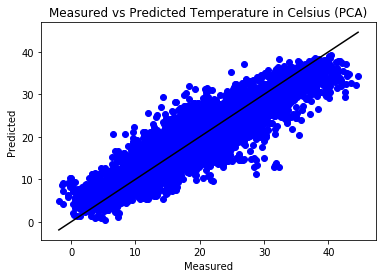

In [8]:
mean, var = cross_validation(10, data_splits, label_splits)
print("Mean of regression error with random forests and", r," principal components is: ", mean)
print("Variance of regression error with random forests and", r," principal components is: ", var)

#Plotting the classified test data with the actual measurements
x = np.linspace(np.min(air_labels), np.max(air_labels), 1000)
plt.plot(x, x, c="black")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title("Measured vs Predicted Temperature in Celsius (PCA)")
plt.plot()

Comparing the regression results using PCA and not using PCA. This shows the trade-off between computational power and regression accuracy.

Mean of regression error with random forests and original data is:  0.5064870115044295
Variance of regression error with random forests and original data is:  0.5083853848865582


[]

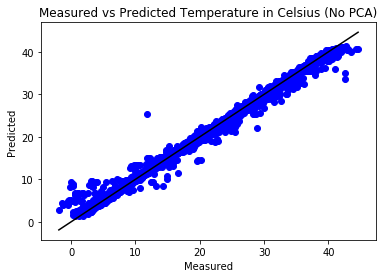

In [9]:
mean, var = cross_validation(10, data_splits2, label_splits)
print("Mean of regression error with random forests and original data is: ", mean)
print("Variance of regression error with random forests and original data is: ", var)

#Plotting the classified test data with the actual measurements
x = np.linspace(np.min(air_labels), np.max(air_labels), 1000)
plt.plot(x, x, c="black")
plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title("Measured vs Predicted Temperature in Celsius (No PCA)")
plt.plot()